In [2]:
import importlib
import pandas as pd
import analysis_functions as af
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy import stats
from scipy.io import loadmat
from scipy.ndimage import uniform_filter1d
import os
import pickle
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter1d
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

In [124]:
# Load the ctl data
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1ctldata_full.pkl")
with open(desktop_path, 'rb') as f:
    data_ctl_full = pickle.load(f)

    
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1_ctldata.pkl")
with open(desktop_path, 'rb') as f:
    data_ctl = pickle.load(f)


time_ctl = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\time_ctldata.mat")
time_full_ctl = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\time_ctldata_full.mat")
for ani in data_ctl:
    data_ctl[ani]['time'] = np.squeeze(time_ctl['time'][0][ani])
for ani in data_ctl_full:
    data_ctl_full[ani]['time'] = np.squeeze(time_full_ctl['t'][0][ani])

reward_trigger_ctl = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\rewardtrigger_ctl.mat")
for ani in data_ctl_full:
    del data_ctl_full[ani]['reward_indices']
    data_ctl_full[ani]['reward_indices'] = np.squeeze(reward_trigger_ctl['rewardtrigger_ctl'][0][ani])

reward_trigger_ctl_ds = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\downsampled_rewardtrigger_ctl.mat")
for ani in data_ctl:
    del data_ctl[ani]['reward_indices']
    data_ctl[ani]['reward_indices'] = np.squeeze(reward_trigger_ctl_ds['downsampled_rewardtrigger_ctl'][0][ani])


# Load the tst data 
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1tstdata_full.pkl")
with open(desktop_path, 'rb') as f:
    data_tst_full = pickle.load(f)
    data_tst_full.pop(13)
    
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1_tstdata.pkl")
with open(desktop_path, 'rb') as f:
    data_tst = pickle.load(f)
    data_tst.pop(13) # no speed and lick data in this animal

time_tst = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\time_tstdata.mat")
time_full_tst = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\time_tstdata_full.mat")
for ani in data_tst:
    data_tst[ani]['time'] = np.squeeze(time_tst['time'][0][ani])
for ani in data_tst_full:
    data_tst_full[ani]['time'] = np.squeeze(time_full_tst['time'][0][ani])

reward_trigger_tst = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\rewardtrigger_tst.mat")
for ani in data_tst_full:
    del data_tst_full[ani]['reward_indices']
    data_tst_full[ani]['reward_indices'] = np.squeeze(reward_trigger_tst['rewardtrigger_tst'][0][ani])

reward_trigger_tst_ds = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\downsampled_rewardtrigger_tst.mat")
for ani in data_tst:
    del data_tst[ani]['reward_indices']
    data_tst[ani]['reward_indices'] = np.squeeze(reward_trigger_tst_ds['downsampled_rewardtrigger_tst'][0][ani])

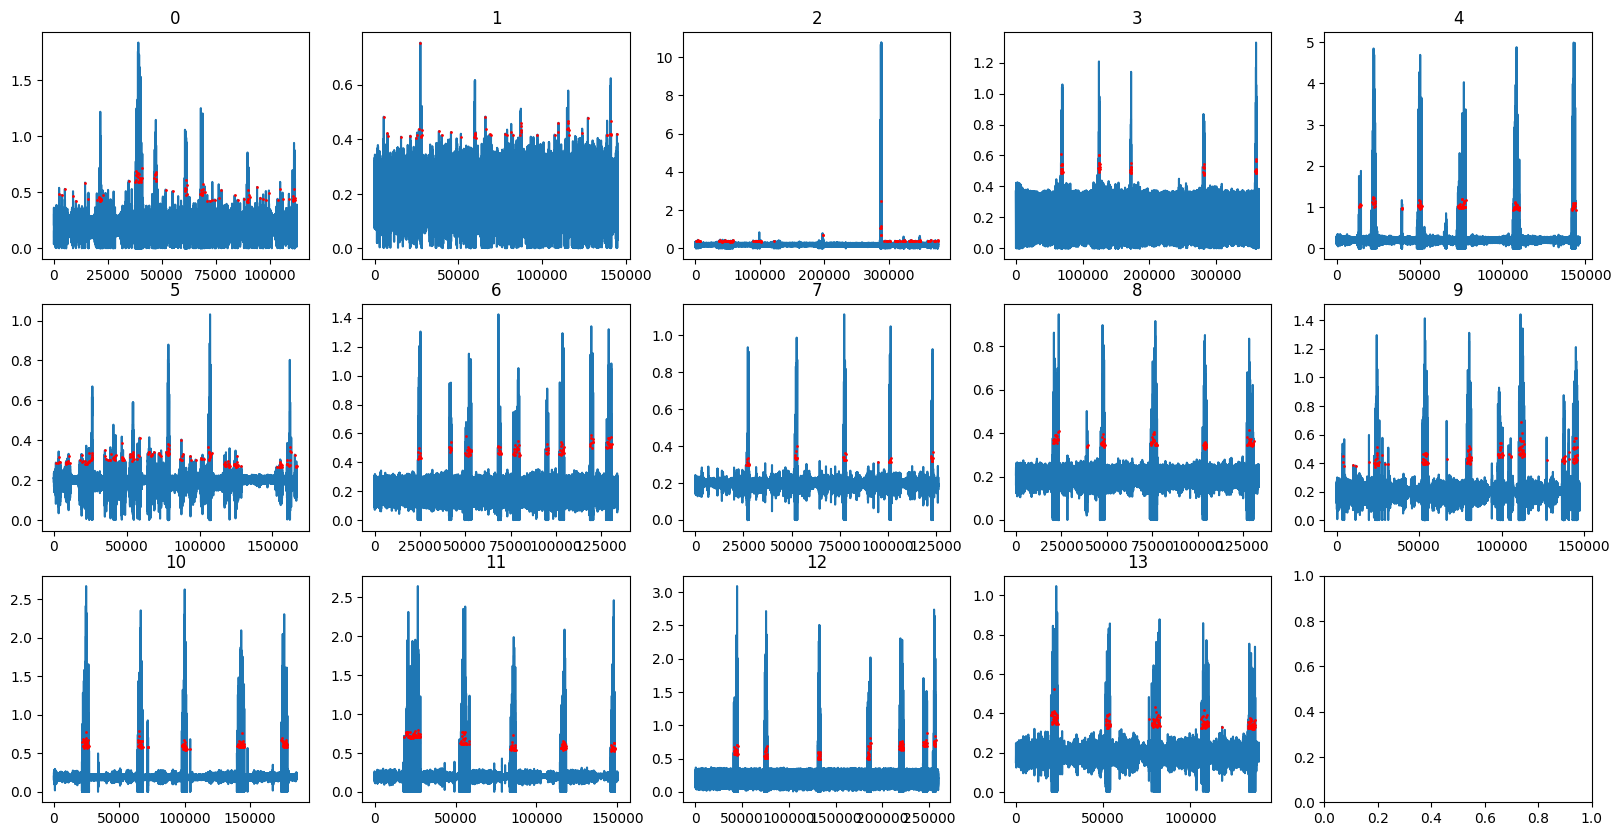

In [250]:
# find lick indices in nondownsampled data and get lick_onsets/lick_records/lick_rate in downsampled data--- ctl

lick_onsets_ctl = {}
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

max_valid = 5
min_interval = 100   # refractory period in samples

for ani in data_ctl_full:
    lick_onsets_ctl[ani] = []
    lick_signal_raw = np.clip(data_ctl_full[ani]['lick'], a_min=None, a_max=max_valid)
    lick_signal = gaussian_filter1d(lick_signal_raw, sigma=0.1)  # no smoothing

    trial_start_indices = data_ctl_full[ani]['trial_start_indices']

    # iterate over all trials
    for tri in range(len(trial_start_indices) - 1):
        start = trial_start_indices[tri]
        end = trial_start_indices[tri + 1]
        segment = lick_signal[start:end]
        
        # compute per-trial threshold
        # threshold = 0.4
        threshold = np.median(segment) + 3 * np.std(segment)

        # find threshold crossings
        above = segment > threshold
        crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1 

        # convert local indices to absolute indices
        if len(crossings) > 0:
            # enforce refractory period (in absolute frame)
            abs_cross = start + crossings
            if len(abs_cross) > 0:
                filtered = [abs_cross[0]]
                for idx in abs_cross[1:]:
                    if idx - filtered[-1] >= min_interval:
                        filtered.append(idx)
                lick_onsets_ctl[ani].extend(filtered)

# convert to numpy arrays and visualise 
for ani in lick_onsets_ctl:
    lick_onsets_ctl[ani] = np.array(lick_onsets_ctl[ani])

    trial_start_indices = data_ctl_full[ani]['trial_start_indices']
    start, end = trial_start_indices[15], trial_start_indices[20]
    lick_signal = data_ctl_full[ani]['lick'] 
    axes[ani].plot(lick_signal[start:end])
    axes[ani].set_title(f'{ani}')
    # axes[ani].axhline(0.2,c='red')

    onsets_in_segment = lick_onsets_ctl[ani][
        (lick_onsets_ctl[ani] >= start) & (lick_onsets_ctl[ani] < end)
    ]
    rel_onsets = onsets_in_segment - start
    axes[ani].scatter(
        rel_onsets,
        lick_signal[onsets_in_segment],
        color='red', s=1, zorder=3
    )


# Calculate the Lick Rate
lick_rate_ctl = {}
window_ms = 200  # 1-second sliding window
sampling_rate = 1000  # Hz
for ani in data_ctl_full:
    # Make binary lick signal
    n_samples = len(data_ctl_full[ani]['time'])
    lick_signal = np.zeros(n_samples)
    lick_signal[lick_onsets_ctl[ani]] = 1
    # Sliding window average (licks per sample)
    rate_per_sample = uniform_filter1d(lick_signal, size=window_ms, mode='constant')
    # Convert to licks per second
    lick_rate_ctl[ani] = rate_per_sample * sampling_rate

# Find the lick indices in the downsampled data and get a new lick_onsets_ctl
lick_onsets_ctl_ds = {}
for ani in data_ctl_full:
    times_full = data_ctl_full[ani]['time']
    times_ds = data_ctl[ani]['time']
    lick_onsets_ctl_ds[ani] = [] 
    for lick_ind in lick_onsets_ctl[ani]:
        lick_time = times_full[lick_ind]
        i = np.argmin(np.abs(times_ds - lick_time))   # find the time_ds closest to lick_time and use that index
        if 0 <= i < len(times_ds): 
            lick_onsets_ctl_ds[ani].append(i)
    lick_onsets_ctl_ds[ani] = np.array(lick_onsets_ctl_ds[ani])


# Get the lick_record
lick_record_ctl = {}
for ani in data_ctl:
    lick_record_ctl[ani] = np.zeros(data_ctl[ani]['lick'].shape[0])
    for num in lick_onsets_ctl_ds[ani]:
        lick_record_ctl[ani][num] = 1


lick_rate_ctl_ds = {}
window_frames = 4
for ani in data_ctl:
    lick_series = pd.Series(lick_record_ctl[ani])
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum() 
    lick_rate_ctl_ds[ani] = np.array(lick_count)*7.5/window_frames   # Convert to licks/sec (since window is 1 sec, no need to change)

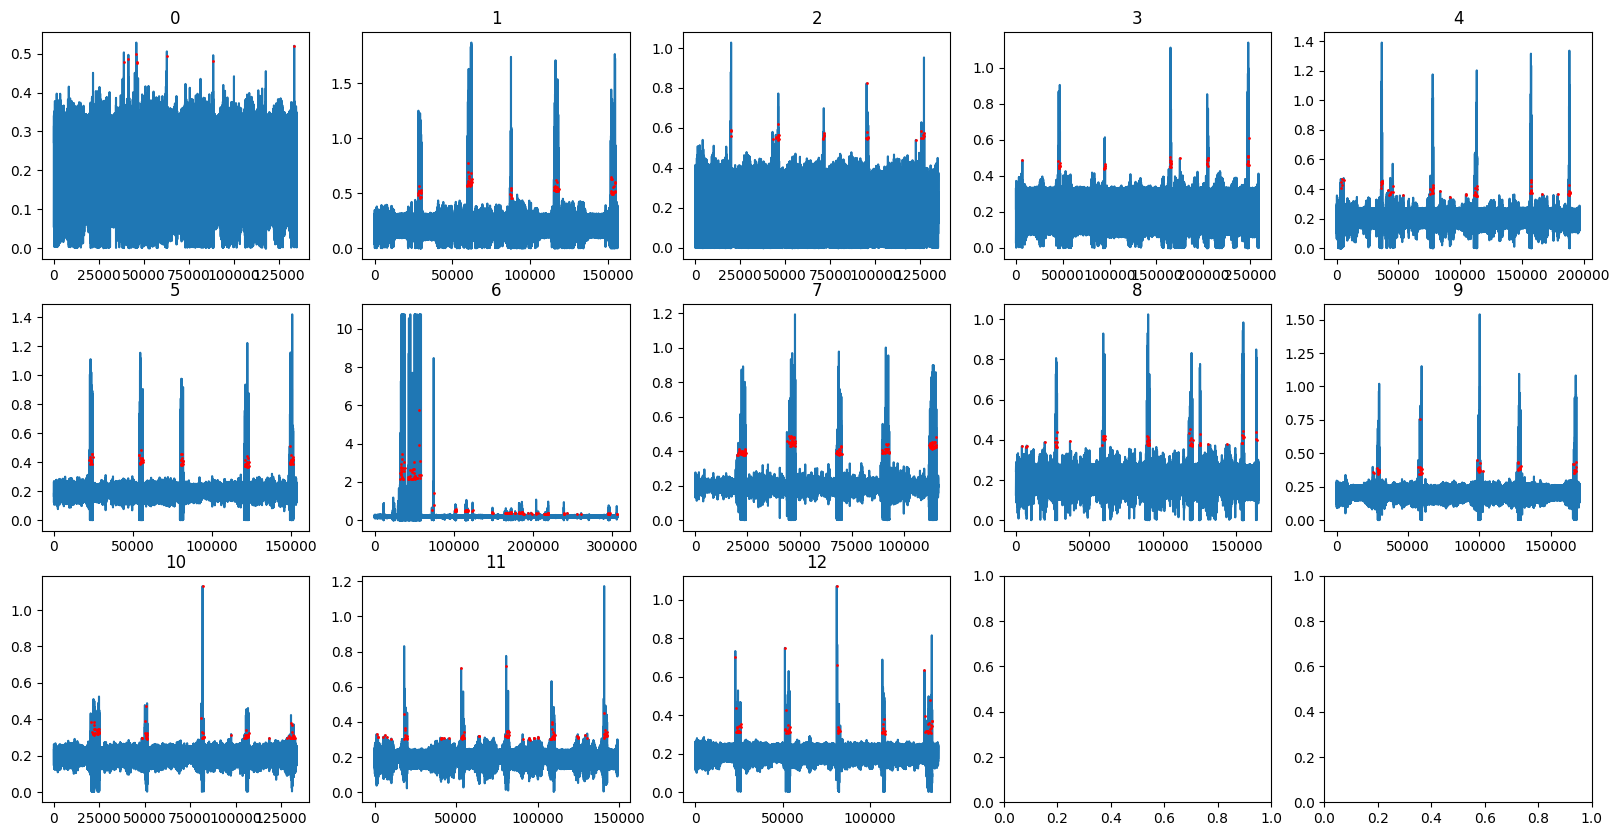

In [309]:
# find lick indices in nondownsampled data and get lick_onsets/lick_records/lick_rate in downsampled data--- tst

lick_onsets_tst = {}
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

max_valid = 5
min_interval = 100   # refractory period in samples

for ani in data_tst_full:
    lick_onsets_tst[ani] = []

    lick_signal_raw = np.clip(data_tst_full[ani]['lick'], a_min=None, a_max=max_valid)
    lick_signal = gaussian_filter1d(lick_signal_raw, sigma=0.1)  # optional smoothing

    trial_start_indices = data_tst_full[ani]['trial_start_indices']

    # iterate over all trials
    for tri in range(len(trial_start_indices) - 1):
        start = trial_start_indices[tri]
        end = trial_start_indices[tri + 1]
        segment = lick_signal[start:end]
        
        # threshold = 0.4
        threshold = np.median(segment) + 3 * np.std(segment)

        # find threshold crossings
        above = segment > threshold
        crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1 

        # convert local indices to absolute indices
        if len(crossings) > 0:
            # enforce refractory period (in absolute frame)
            abs_cross = start + crossings
            if len(abs_cross) > 0:
                filtered = [abs_cross[0]]
                for idx in abs_cross[1:]:
                    if idx - filtered[-1] >= min_interval:
                        filtered.append(idx)
                lick_onsets_tst[ani].extend(filtered)

# convert to numpy arrays
for ani in lick_onsets_tst:
    
    lick_onsets_tst[ani] = np.array(lick_onsets_tst[ani])
    
    trial_start_indices = data_tst_full[ani]['trial_start_indices']
    start, end = trial_start_indices[15], trial_start_indices[20]
    lick_signal = data_tst_full[ani]['lick'] 
    axes[ani].plot(lick_signal[start:end])
    axes[ani].set_title(f'{ani}')
    # axes[ani].axhline(0.2,c='red')

    onsets_in_segment = lick_onsets_tst[ani][
        (lick_onsets_tst[ani] >= start) & (lick_onsets_tst[ani] < end)
    ]
    rel_onsets = onsets_in_segment - start
    axes[ani].scatter(
        rel_onsets,
        lick_signal[onsets_in_segment],
        color='red', s=1, zorder=3
    )

# Calculate the Lick Rate

lick_rate_tst = {}
window_ms = 200  # 1-second sliding window
sampling_rate = 1000  # Hz
for ani in data_tst_full:
    # Make binary lick signal
    n_samples = len(data_tst_full[ani]['time'])
    lick_signal = np.zeros(n_samples)
    lick_signal[lick_onsets_tst[ani]] = 1
    # Sliding window average (licks per sample)
    rate_per_sample = uniform_filter1d(lick_signal, size=window_ms, mode='constant')
    # Convert to licks per second
    lick_rate_tst[ani] = rate_per_sample * sampling_rate


# Find the lick indices in the downsampled data and get a new lick_onsets_tst

lick_onsets_tst_ds = {}
for ani in data_tst_full:
    times_full = data_tst_full[ani]['time']
    times_ds = data_tst[ani]['time']
    lick_onsets_tst_ds[ani] = [] 
    for lick_ind in lick_onsets_tst[ani]:
        lick_time = times_full[lick_ind]
        i = np.argmin(np.abs(times_ds - lick_time))   # find the time_ds closest to lick_time and use that index
        if 0 <= i < len(times_ds): 
            lick_onsets_tst_ds[ani].append(i)
    lick_onsets_tst_ds[ani] = np.array(lick_onsets_tst_ds[ani])


# Get the lick_record

lick_record_tst = {}
for ani in data_tst:
    lick_record_tst[ani] = np.zeros(data_tst[ani]['lick'].shape[0])
    for num in lick_onsets_tst_ds[ani]:
        lick_record_tst[ani][num] = 1


lick_rate_tst_ds = {}
window_frames = 4
for ani in data_tst:
    lick_series = pd.Series(lick_record_tst[ani])
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum() 
    lick_rate_tst_ds[ani] = np.array(lick_count)*7.5/window_frames   # Convert to licks/sec (since window is 1 sec, no need to change)

In [300]:
def plot_lick_data(ani):  # function that plot lick raster
    ani_positions = data_ctl[ani]['real_position'] * 700/5
    aligned_exp = []
    aligned_unexp = []
    for i, trial_start in enumerate(data_ctl[ani]['trial_start_indices']):   # i is the trial number and trial_start is the index
        if i < len(data_ctl[ani]['trial_start_indices']) - 1:   
            trial_end = data_ctl[ani]['trial_start_indices'][i+1]   
        else:
            trial_end = len(data_ctl[ani]['real_position'])
        for num, lick in enumerate(lick_record_ctl[ani][trial_start:trial_end]):   # num is the index in [trial_start:trial_end]
            if lick == 1 and i in data_ctl[ani]['unpred_trials']['gr_2']:
                aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
            if lick == 1 and i in data_ctl[ani]['pred_trials']:
                aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
    aligned_exp = np.array(aligned_exp)
    aligned_unexp = np.array(aligned_unexp)

    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    axes[0].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
    axes[0].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
    axes[0].axvline(x=4.62*700/5, color='red', linestyle='-', linewidth=1, label='Reward position')
    # axes[0].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1, label='Grating 2 position')
    axes[0].legend(loc='upper left')
    axes[0].set_title('Control')
    axes[0].set_xlabel('Position (cm)')
    axes[0].set_ylabel('Trial number')
    fig.suptitle('')

    ani_positions = data_tst[ani]['real_position'] * 700/5
    aligned_exp = []
    aligned_unexp = []
    for i, trial_start in enumerate(data_tst[ani]['trial_start_indices']):   # i is the trial number and trial_start is the index
        if i < len(data_tst[ani]['trial_start_indices']) - 1:   
            trial_end = data_tst[ani]['trial_start_indices'][i+1]   
        else:
            trial_end = len(data_tst[ani]['real_position'])
        for num, lick in enumerate(lick_record_tst[ani][trial_start:trial_end]):   # num is the index
            if lick == 1 and i in data_tst[ani]['unpred_trials']['gr_2']:
                aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
            if lick == 1 and i in data_tst[ani]['pred_trials']:
                aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
    aligned_exp = np.array(aligned_exp)
    aligned_unexp = np.array(aligned_unexp)

    axes[1].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
    axes[1].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
    axes[1].axvline(x=4.62*700/5, color='red', linestyle='-', linewidth=1, label='Reward position')
    # axes[1].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1, label='Grating 2 position')
    axes[1].legend(loc='upper left')
    axes[1].set_title('Test')
    axes[1].set_xlabel('Position (cm)')
    plt.tight_layout()
    plt.show()

In [132]:
def plot_one_ani(ani_number,dataset,trial_number):
    
    dataset = dataset
    lick_onsets_ctl = {}
    
    fig, axes = plt.subplots(figsize=(10, 5))

    max_valid = 5
    min_interval = 100   # refractory period in samples

    for ani in dataset:
        lick_onsets_ctl[ani] = []

        lick_signal_raw = np.clip(dataset[ani]['lick'], a_min=None, a_max=max_valid)
        lick_signal = gaussian_filter1d(lick_signal_raw, sigma=0.1)  # optional smoothing

        trial_start_indices = dataset[ani]['trial_start_indices']

        # iterate over all trials
        for tri in range(len(trial_start_indices) - 1):
            start = trial_start_indices[tri]
            end = trial_start_indices[tri + 1]
            segment = lick_signal[start:end]

            # lower, upper = np.percentile(segment, [20, 80]) 
            # clipped = segment[(segment > lower) & (segment < upper)]
            # threshold = np.median(clipped) + 5 * np.std(clipped)
            # print(threshold)

            # compute per-trial threshold
            threshold = np.median(segment) + 3 * np.std(segment)

            # find threshold crossings
            above = segment > threshold
            crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1 

            # convert local indices to absolute indices
            if len(crossings) > 0:
                # enforce refractory period (in absolute frame)
                abs_cross = start + crossings
                if len(abs_cross) > 0:
                    filtered = [abs_cross[0]]
                    for idx in abs_cross[1:]:
                        if idx - filtered[-1] >= min_interval:
                            filtered.append(idx)
                    lick_onsets_ctl[ani].extend(filtered)

    # convert to numpy arrays for convenience
    ani = ani_number
    lick_onsets_ctl[ani] = np.array(lick_onsets_ctl[ani])

    reward_indices = dataset[ani]['reward_indices']
    trial_start_indices = dataset[ani]['trial_start_indices']

    tri = trial_number

    start, end = trial_start_indices[tri], trial_start_indices[tri+5]
    lick_signal = dataset[ani]['lick'] 

    axes.plot(lick_signal[start:end])
    axes.set_title(f'{ani}')
    axes.set_ylim([0,1])
    # axes.axhline(0.3,c='red')
    axes.axvline(reward_indices[tri+1]-start,c='red')
    axes.axvline(reward_indices[tri+2]-start,c='red')
    axes.axvline(reward_indices[tri+3]-start,c='red')
    axes.axvline(reward_indices[tri+4]-start,c='red')

    onsets_in_segment = lick_onsets_ctl[ani][
        (lick_onsets_ctl[ani] >= start) & (lick_onsets_ctl[ani] < end)
    ]

    rel_onsets = onsets_in_segment - start

    axes.scatter(
        rel_onsets,
        lick_signal[onsets_in_segment],
        color='red', s=3, zorder=3
    )

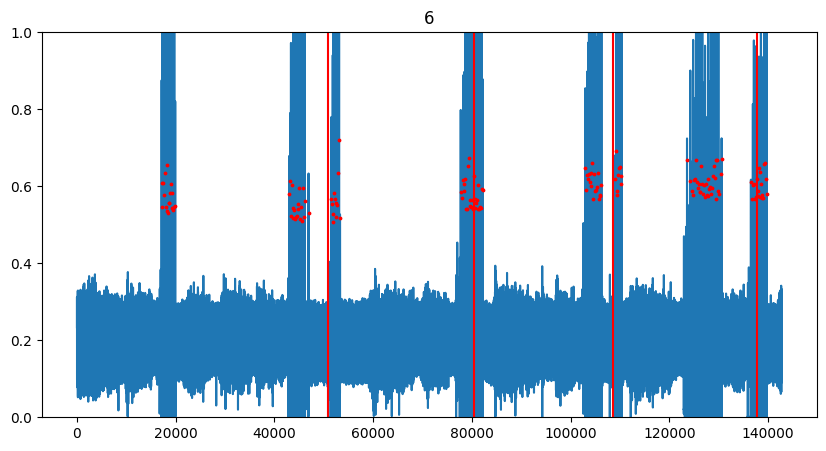

In [133]:
plot_one_ani(6, data_ctl_full, 100)

In [311]:
animal_ctl = [1,2,3,4,6,7,8,9,10,11,12]
animal_tst = [1,2,3,5,6,9,10,12]

1


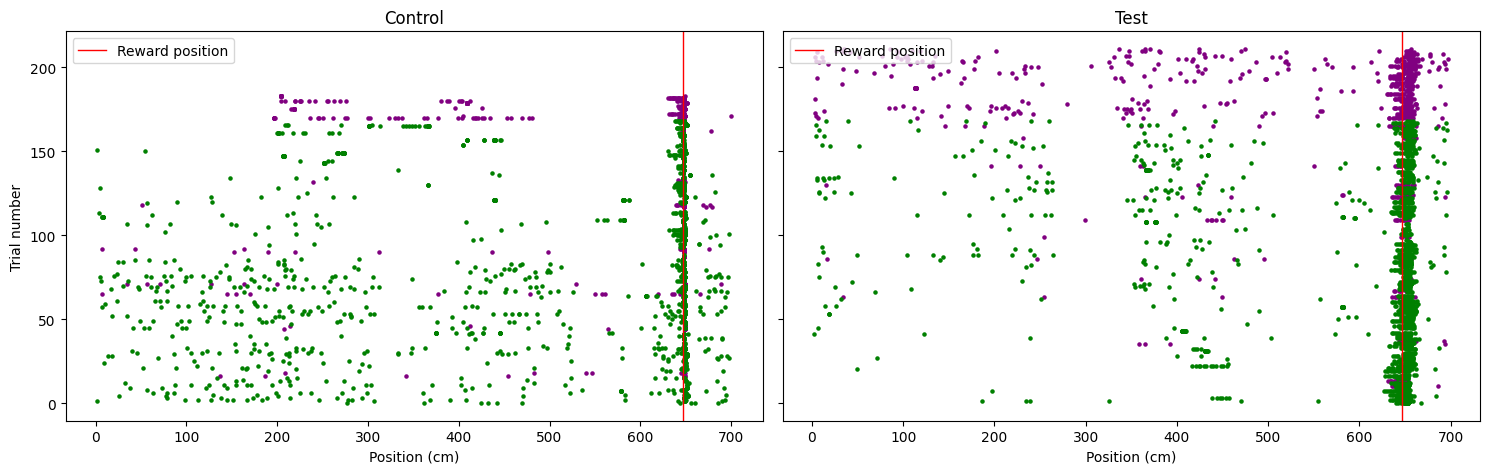

In [310]:
for ani in animal_ctl:
    print(ani)
    plot_lick_data(ani)

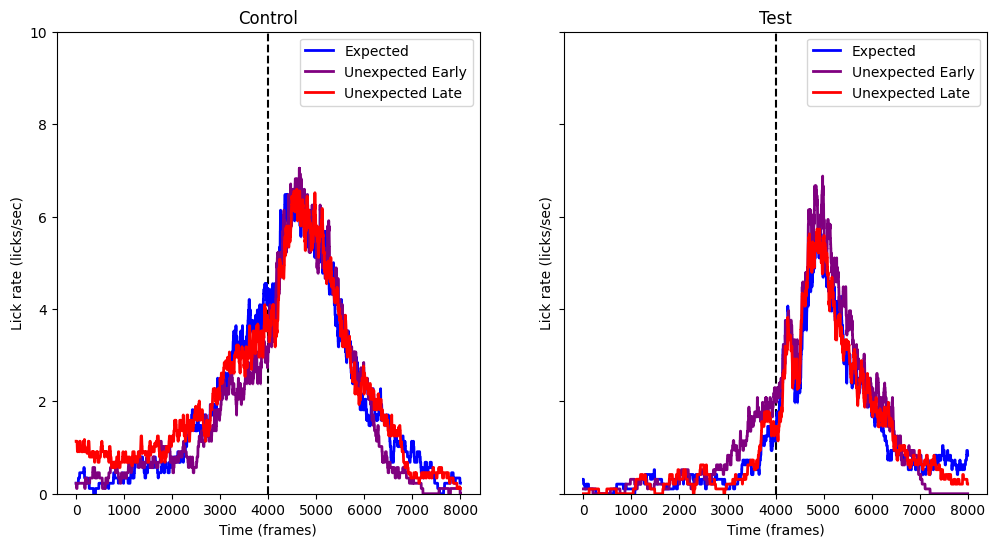

In [ ]:
# Lick Rate --- nondonwsampled 
#ctl
unexp_data = {}
for ani in animal_ctl:
    unexp_data[ani] = []
    for trial in data_ctl_full[ani]['unpred_trials']['gr_2'][:4]:
        unexp_data[ani].append(lick_rate_ctl[ani][range(data_ctl_full[ani]['reward_indices'][trial]-4000, data_ctl_full[ani]['reward_indices'][trial]+4000)])
exp_data = {}
for ani in animal_ctl:
    exp_data[ani] = []
    for trial in data_ctl_full[ani]['unpred_trials']['gr_2'][6:10]:
        exp_data[ani].append(lick_rate_ctl[ani][range(data_ctl_full[ani]['reward_indices'][trial-1]-4000, data_ctl_full[ani]['reward_indices'][trial-1]+4000)])
unexp_late_data = {}
for ani in animal_ctl:
    unexp_late_data[ani] = []
    for trial in data_ctl_full[ani]['unpred_trials']['gr_2'][6:10]:
        unexp_late_data[ani].append(lick_rate_ctl[ani][range(data_ctl_full[ani]['reward_indices'][trial]-4000, data_ctl_full[ani]['reward_indices'][trial]+4000)])

exp_color = 'blue'
unexp_color = 'purple'
unexp_late_color = 'red'

# control
unexp_early = np.mean(np.stack([unexp_data[ani] for ani in animal_ctl]),axis = 1)
exp = np.mean(np.stack([exp_data[ani] for ani in animal_ctl]),axis = 1)
unexp_late = np.mean(np.stack([unexp_late_data[ani] for ani in animal_ctl]),axis = 1)

x_vals = np.arange(exp.shape[1])
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes[0].set_ylim([0,10])
axes[0].axvline(4000, linestyle='--', color='k')
af.plot_shaded_error(axes[0], x_vals, exp, color=exp_color, label='Expected')
af.plot_shaded_error(axes[0], x_vals, unexp_early, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[0], x_vals, unexp_late, color=unexp_late_color, label='Unexpected Late', style='smooth')
axes[0].set_title('Control')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Lick rate (licks/sec)')
axes[0].legend()

# tst
unexp_data = {}
for ani in animal_tst:
    unexp_data[ani] = []
    for trial in data_tst_full[ani]['unpred_trials']['gr_2'][:4]:
        unexp_data[ani].append(lick_rate_tst[ani][range(data_tst_full[ani]['reward_indices'][trial]-4000, data_tst_full[ani]['reward_indices'][trial]+4000)])
exp_data = {}
for ani in animal_tst:
    exp_data[ani] = []
    for trial in data_tst_full[ani]['unpred_trials']['gr_2'][6:10]:
        exp_data[ani].append(lick_rate_tst[ani][range(data_tst_full[ani]['reward_indices'][trial-1]-4000, data_tst_full[ani]['reward_indices'][trial-1]+4000)])
unexp_late_data = {}
for ani in animal_tst:
    unexp_late_data[ani] = []
    for trial in data_tst_full[ani]['unpred_trials']['gr_2'][6:10]:
        unexp_late_data[ani].append(lick_rate_tst[ani][range(data_tst_full[ani]['reward_indices'][trial]-4000, data_tst_full[ani]['reward_indices'][trial]+4000)])

exp_color = 'blue'
unexp_color = 'purple'
unexp_late_color = 'red'

# test
unexp_early = np.mean(np.stack([unexp_data[ani] for ani in animal_tst]), axis=1)
exp = np.mean(np.stack([exp_data[ani] for ani in animal_tst]), axis=1)
unexp_late = np.mean(np.stack([unexp_late_data[ani] for ani in animal_tst]), axis=1)

x_vals = np.arange(exp.shape[1])
axes[1].set_ylim([0,10])
axes[1].axvline(4000, linestyle='--', color='k')
af.plot_shaded_error(axes[1], x_vals, exp, color=exp_color, label='Expected')
af.plot_shaded_error(axes[1], x_vals, unexp_early, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[1], x_vals, unexp_late, color=unexp_late_color, label='Unexpected Late', style='smooth')
axes[1].set_title('Test')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Lick rate (licks/sec)')
axes[1].legend()


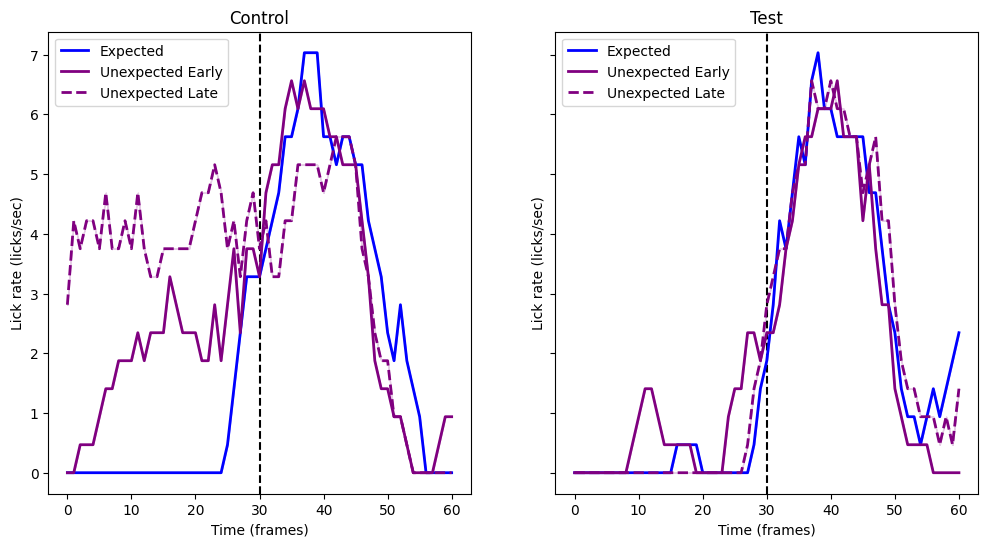

In [230]:
#ctl --- downsampled lick rate

unexp_data = {}
for ani in animal_ctl:
    unexp_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][:4]:
        unexp_data[ani].append(lick_rate_ctl_ds[ani][range(data_ctl[ani]['reward_indices'][trial]-30,data_ctl[ani]['reward_indices'][trial]+31)])
exp_data = {}
for ani in animal_ctl:
    exp_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][:4]:
        exp_data[ani].append(lick_rate_ctl_ds[ani][range(data_ctl[ani]['reward_indices'][trial-1]-30,data_ctl[ani]['reward_indices'][trial-1]+31)])
unexp_late_data = {}
for ani in animal_ctl:
    unexp_late_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][6:10]:
        unexp_late_data[ani].append(lick_rate_ctl_ds[ani][range(data_ctl[ani]['reward_indices'][trial]-30,data_ctl[ani]['reward_indices'][trial]+31)])

exp_color = 'blue'
unexp_color = 'purple'
# control
unexp_early = np.mean(np.stack([unexp_data[ani] for ani in animal_ctl]),axis = 1)
exp = np.mean(np.stack([exp_data[ani] for ani in animal_ctl]),axis = 1)
unexp_late = np.mean(np.stack([unexp_late_data[ani] for ani in animal_ctl]),axis = 1)

x_vals = np.arange(exp.shape[1])
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
# axes[0].set_ylim([0,6])
axes[0].axvline(30, linestyle='--', color='k')
af.plot_shaded_error(axes[0], x_vals, exp, color=exp_color, label='Expected')
af.plot_shaded_error(axes[0], x_vals, unexp_early, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[0], x_vals, unexp_late, color=unexp_color, label='Unexpected Late', style='dash')
axes[0].set_title('Control')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Lick rate (licks/sec)')
axes[0].legend()

# tst
unexp_data = {}
for ani in animal_tst:
    unexp_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][:4]:
        unexp_data[ani].append(lick_rate_tst_ds[ani][range(data_tst[ani]['reward_indices'][trial]-30,data_tst[ani]['reward_indices'][trial]+31)])
exp_data = {}
for ani in animal_tst:
    exp_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][6:10]:
        exp_data[ani].append(lick_rate_tst_ds[ani][range(data_tst[ani]['reward_indices'][trial-1]-30,data_tst[ani]['reward_indices'][trial-1]+31)])
unexp_late_data = {}
for ani in animal_tst:
    unexp_late_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][6:10]:
        unexp_late_data[ani].append(lick_rate_tst_ds[ani][range(data_tst[ani]['reward_indices'][trial]-30,data_tst[ani]['reward_indices'][trial]+31)])
exp_color = 'blue'
unexp_color = 'purple'

# test
unexp_early = np.mean(np.stack([unexp_data[ani] for ani in animal_tst]), axis=1)
exp = np.mean(np.stack([exp_data[ani] for ani in animal_tst]), axis=1)
unexp_late = np.mean(np.stack([unexp_late_data[ani] for ani in animal_tst]), axis=1)

x_vals = np.arange(exp.shape[1])
axes[1].axvline(30, linestyle='--', color='k')
af.plot_shaded_error(axes[1], x_vals, exp, color=exp_color, label='Expected')
af.plot_shaded_error(axes[1], x_vals, unexp_early, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[1], x_vals, unexp_late, color=unexp_color, label='Unexpected Late', style='dash')
axes[1].set_title('Test')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Lick rate (licks/sec)')
axes[1].legend()

In [ ]:
#  non anticipatory:   ctl 7 12

In [ ]:
definitely anticipatory: 3,4,6,8,9,10,11    ctl

1, 10, 

In [ ]:
#

animal_ctl = [1,2,3,4,6,7,8,9,10,11,12]
animal_tst = [1,2,3,5,6,9,10,12]

In [307]:
animal_ctl = [1,2,3,4,6,7,8,9,10,11,12]
animal_tst = [1,2,3,5,6,9,10,12]
animal_ctl = [1]
animal_tst = [11]

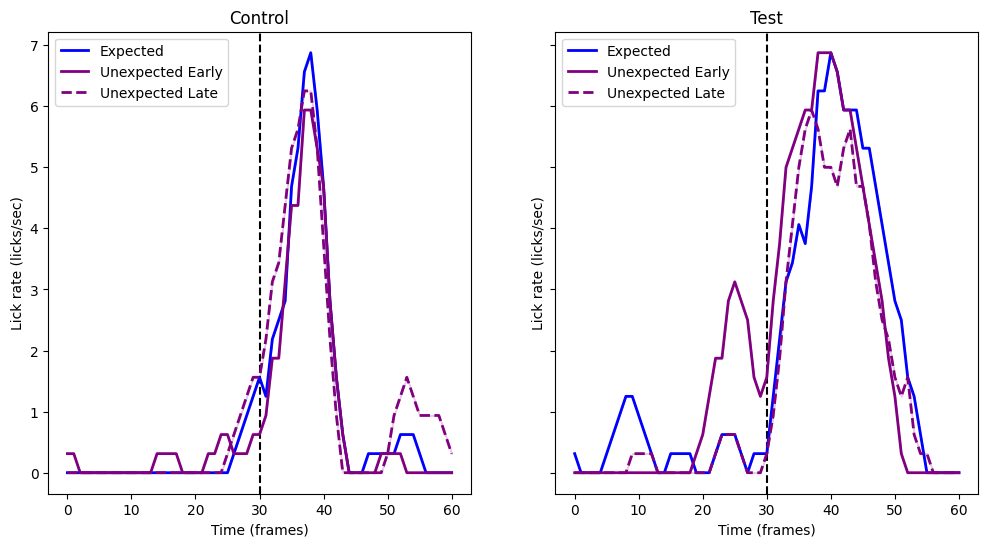

In [308]:
#ctl --- downsampled lick rate

unexp_data = {}
for ani in animal_ctl:
    unexp_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][:6]:
        unexp_data[ani].append(lick_rate_ctl_ds[ani][range(data_ctl[ani]['reward_indices'][trial]-30,data_ctl[ani]['reward_indices'][trial]+31)])
exp_data = {}
for ani in animal_ctl:
    exp_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][6:12]:
        exp_data[ani].append(lick_rate_ctl_ds[ani][range(data_ctl[ani]['reward_indices'][trial-1]-30,data_ctl[ani]['reward_indices'][trial-1]+31)])
unexp_late_data = {}
for ani in animal_ctl:
    unexp_late_data[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2'][6:12]:
        unexp_late_data[ani].append(lick_rate_ctl_ds[ani][range(data_ctl[ani]['reward_indices'][trial]-30,data_ctl[ani]['reward_indices'][trial]+31)])

exp_color = 'blue'
unexp_color = 'purple'
# control
unexp_early = np.mean(np.stack([unexp_data[ani] for ani in animal_ctl]),axis = 1)
exp = np.mean(np.stack([exp_data[ani] for ani in animal_ctl]),axis = 1)
unexp_late = np.mean(np.stack([unexp_late_data[ani] for ani in animal_ctl]),axis = 1)

x_vals = np.arange(exp.shape[1])
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes[0].axvline(30, linestyle='--', color='k')
af.plot_shaded_error(axes[0], x_vals, exp, color=exp_color, label='Expected')
af.plot_shaded_error(axes[0], x_vals, unexp_early, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[0], x_vals, unexp_late, color=unexp_color, label='Unexpected Late', style='dash')
axes[0].set_title('Control')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Lick rate (licks/sec)')
axes[0].legend()

# tst
unexp_data = {}
for ani in animal_tst:
    unexp_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][:6]:
        unexp_data[ani].append(lick_rate_tst_ds[ani][range(data_tst[ani]['reward_indices'][trial]-30,data_tst[ani]['reward_indices'][trial]+31)])
exp_data = {}
for ani in animal_tst:
    exp_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][6:12]:
        exp_data[ani].append(lick_rate_tst_ds[ani][range(data_tst[ani]['reward_indices'][trial-1]-30,data_tst[ani]['reward_indices'][trial-1]+31)])
unexp_late_data = {}
for ani in animal_tst:
    unexp_late_data[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2'][6:12]:
        unexp_late_data[ani].append(lick_rate_tst_ds[ani][range(data_tst[ani]['reward_indices'][trial]-30,data_tst[ani]['reward_indices'][trial]+31)])
exp_color = 'blue'
unexp_color = 'purple'

# test
unexp_early = np.mean(np.stack([unexp_data[ani] for ani in animal_tst]), axis=1)
exp = np.mean(np.stack([exp_data[ani] for ani in animal_tst]), axis=1)
unexp_late = np.mean(np.stack([unexp_late_data[ani] for ani in animal_tst]), axis=1)

x_vals = np.arange(exp.shape[1])
axes[1].axvline(30, linestyle='--', color='k')
af.plot_shaded_error(axes[1], x_vals, exp, color=exp_color, label='Expected')
af.plot_shaded_error(axes[1], x_vals, unexp_early, color=unexp_color, label='Unexpected Early')
af.plot_shaded_error(axes[1], x_vals, unexp_late, color=unexp_color, label='Unexpected Late', style='dash')
axes[1].set_title('Test')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Lick rate (licks/sec)')
axes[1].legend()

In [ ]:
# three points plot function
def compute_unexp_exp_rw(data_group, group_name):
    unexp_rw = {}
    exp_rw = {}
    for ani in data_group:
        unexp_rw[ani] = []
        exp_rw[ani] = []
        for trial in data_group[ani]['unpred_trials']['gr_2']:
            unexp_rw[ani].append(data_group[ani]['reward_indices'][trial])
        for trial in data_group[ani]['unpred_trials']['gr_2']:
            exp_rw[ani].append(data_group[ani]['reward_indices'][trial - 1])
    return unexp_rw, exp_rw


def three_points_plot(ctl_animals,tst_animals):

    # compute reward indices
    unexp_rw_ctl, exp_rw_ctl = compute_unexp_exp_rw(data_ctl, 'control')
    unexp_rw_tst, exp_rw_tst = compute_unexp_exp_rw(data_tst, 'test')


    # ==========================
    # PLOT CONTROL GROUP
    # ==========================
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ax = axes.flatten()


    ctl_animals = ctl_animals  
    tst_animals = tst_animals  


    # -------- CONTROL --------
    results_ctl = []
    for ani in ctl_animals:
        arr = lick_record_ctl[ani][exp_rw_ctl[ani][6:10]]
        first_lick_exp_B = [30 - np.where(row == 1)[0][0] if np.any(row == 1) else -30 for row in arr]

        arr = lick_record_ctl[ani][unexp_rw_ctl[ani][:4]]
        first_lick_unexp_X = [30 - np.where(row == 1)[0][0] if np.any(row == 1) else -30 for row in arr]

        arr = lick_record_ctl[ani][unexp_rw_ctl[ani][6:10]]
        first_lick_exp_X = [30 - np.where(row == 1)[0][0] if np.any(row == 1) else -30 for row in arr]

        results_ctl.append([
            np.mean(first_lick_exp_B),
            np.mean(first_lick_unexp_X),
            np.mean(first_lick_exp_X)
        ])
    results_ctl = np.array(results_ctl) / 7.5

    colors = ['gray', 'red', 'blue']
    x_positions = [1, 2, 3]

    for i, xpos in enumerate(x_positions):
        ax[0].scatter(np.full(results_ctl.shape[0], xpos),
                    results_ctl[:, i],
                    facecolors='none', edgecolors=colors[i],
                    s=60, linewidth=1.5, zorder=3)
    for animal in results_ctl:
        ax[0].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2)

    for i in range(results_ctl.shape[1]):
        mean_val = np.mean(results_ctl[:, i])
        ax[0].hlines(mean_val, i + 0.8, i + 1.2, color='black', linewidth=2)

    pairs = [(0, 1), (0, 2), (1, 2)]
    pvals_ctl = [wilcoxon(results_ctl[:, i], results_ctl[:, j])[1] for (i, j) in pairs]

    ax[0].set_xticks([1, 2, 3])
    ax[0].set_ylim([-4, 4])
    ax[0].axhline(0,c='black')
    ax[0].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].text(1.5, np.max(results_ctl) + 0.1, f"P={pvals_ctl[0]:.3f}", ha='center')
    ax[0].text(2.5, np.max(results_ctl) + 0.1, f"P={pvals_ctl[2]:.3f}", ha='center')
    ax[0].set_ylabel('Latency (s)')
    ax[0].set_title('Lick Latency (Control)')


    # -------- TEST --------
    results_tst = []
    for ani in tst_animals:
        arr = lick_record_tst[ani][exp_rw_tst[ani][6:10]]
        first_lick_exp_B = [30 - np.where(row == 1)[0][0] if np.any(row == 1) else -30 for row in arr]

        arr = lick_record_tst[ani][unexp_rw_tst[ani][:4]]
        first_lick_unexp_X = [30 - np.where(row == 1)[0][0] if np.any(row == 1) else -30 for row in arr]

        arr = lick_record_tst[ani][unexp_rw_tst[ani][6:10]]
        first_lick_exp_X = [30 - np.where(row == 1)[0][0] if np.any(row == 1) else -30 for row in arr]

        results_tst.append([
            np.mean(first_lick_exp_B),
            np.mean(first_lick_unexp_X),
            np.mean(first_lick_exp_X)
        ])
    results_tst = np.array(results_tst) / 7.5

    for i, xpos in enumerate(x_positions):
        ax[1].scatter(np.full(results_tst.shape[0], xpos),
                    results_tst[:, i],
                    facecolors='none', edgecolors=colors[i],
                    s=60, linewidth=1.5, zorder=3)
    for animal in results_tst:
        ax[1].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2)

    for i in range(results_tst.shape[1]):
        mean_val = np.mean(results_tst[:, i])
        ax[1].hlines(mean_val, i + 0.8, i + 1.2, color='black', linewidth=2)

    pvals_tst = [wilcoxon(results_tst[:, i], results_tst[:, j])[1] for (i, j) in pairs]

    ax[1].set_xticks([1, 2, 3])
    ax[1].set_ylim([-4, 4])
    ax[1].axhline(0,c='black')
    ax[1].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].text(1.5, np.max(results_tst) + 0.1, f"P={pvals_tst[0]:.3f}", ha='center')
    ax[1].text(2.5, np.max(results_tst) + 0.1, f"P={pvals_tst[2]:.3f}", ha='center')
    ax[1].set_ylabel('Latency (s)')
    ax[1].set_title('Lick Latency (Test)')

    plt.tight_layout()
    plt.show()


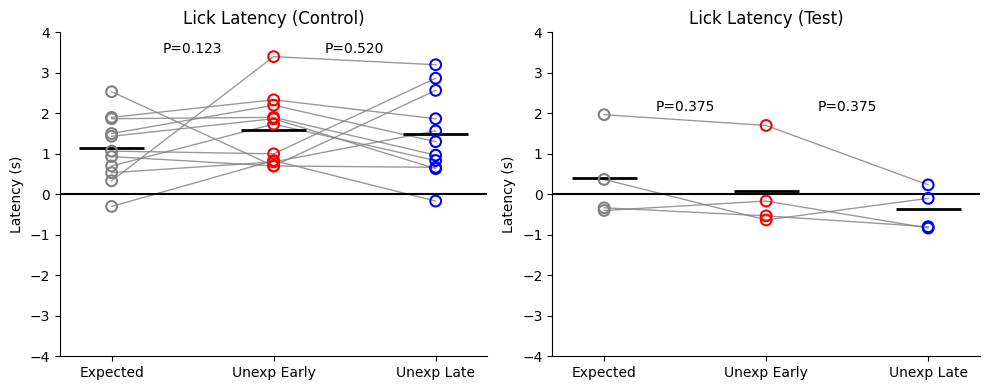

In [242]:
three_points_plot([0,2,3,4,6,8,9,10,11,12,13],[1,3,4,5])